In [1]:
!pip install torch torchvision scikit-learn pandas matplotlib tqdm kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub
from PIL import Image


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\bhara\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_images(folder_path, label):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            images.append((os.path.join(folder_path, file), label))
    return images

data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v2")
data_dir = os.path.join(data_dir, "Glaucoma Dataset for AI Diagnosis")
print("Current Dir:", data_dir, "| Folders:", os.listdir(data_dir))

glaucoma_images = find_images(os.path.join(data_dir, "glaucoma"), 1)
normal_images = find_images(os.path.join(data_dir, "normal"), 0)
all_images = glaucoma_images + normal_images

# Stratified splits: train=596, test=50, val=100
from sklearn.model_selection import train_test_split

# First split: separate test set (50 samples)
train_val_idx, test_idx = train_test_split(
    range(len(all_images)),
    test_size=50,
    stratify=[label for _, label in all_images],
    random_state=42
)

# Second split: separate train and val from remaining data
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=100,
    stratify=[all_images[i][1] for i in train_val_idx],
    random_state=42
)

train_split = [all_images[i] for i in train_idx]
val_split = [all_images[i] for i in val_idx]
test_split = [all_images[i] for i in test_idx]

print("Train Samples:", len(train_split), "Val Samples:", len(val_split), "Test Samples:", len(test_split))

# Save split information to CSV files
import pandas as pd

# Create DataFrames for train, val, and test splits
train_df = pd.DataFrame(train_split, columns=['image_path', 'label'])
val_df = pd.DataFrame(val_split, columns=['image_path', 'label'])
test_df = pd.DataFrame(test_split, columns=['image_path', 'label'])

# Save to CSV files
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print(f"Saved train split to train_split.csv ({len(train_df)} images)")
print(f"Saved val split to val_split.csv ({len(val_df)} images)")
print(f"Saved test split to test_split.csv ({len(test_df)} images)")


Current Dir: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1\Glaucoma Dataset for AI Diagnosis | Folders: ['glaucoma', 'normal']
Train Samples: 3009 Val Samples: 100 Test Samples: 50
Saved train split to train_split.csv (3009 images)
Saved val split to val_split.csv (100 images)
Saved test split to test_split.csv (50 images)


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_split, train_transform)
val_dataset = CustomDataset(val_split, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
EPOCHS = 100
PATIENCE = 7

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"[TRAIN] Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds, epoch_val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(
        f"[EPOCH {epoch+1}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            break

model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")
print("Best model saved to: best_glaucoma_model.pth")


[TRAIN] Epoch 1/100: 100%|██████████| 95/95 [02:29<00:00,  1.57s/it]



[EPOCH 1] Train Loss: 0.2129 | Train Acc: 92.69% || Val Loss: 0.2522 | Val Acc: 94.00%


[TRAIN] Epoch 2/100: 100%|██████████| 95/95 [02:06<00:00,  1.34s/it]



[EPOCH 2] Train Loss: 0.1253 | Train Acc: 94.45% || Val Loss: 0.3765 | Val Acc: 96.00%


[TRAIN] Epoch 3/100: 100%|██████████| 95/95 [02:05<00:00,  1.33s/it]



[EPOCH 3] Train Loss: 0.1109 | Train Acc: 95.45% || Val Loss: 0.1020 | Val Acc: 93.00%


[TRAIN] Epoch 4/100: 100%|██████████| 95/95 [02:07<00:00,  1.34s/it]



[EPOCH 4] Train Loss: 0.1555 | Train Acc: 95.48% || Val Loss: 0.1944 | Val Acc: 95.00%


[TRAIN] Epoch 5/100: 100%|██████████| 95/95 [02:06<00:00,  1.34s/it]



[EPOCH 5] Train Loss: 0.0909 | Train Acc: 96.24% || Val Loss: 0.5347 | Val Acc: 95.00%


[TRAIN] Epoch 6/100: 100%|██████████| 95/95 [02:09<00:00,  1.36s/it]



[EPOCH 6] Train Loss: 0.0897 | Train Acc: 96.21% || Val Loss: 0.3740 | Val Acc: 96.00%


[TRAIN] Epoch 7/100: 100%|██████████| 95/95 [02:07<00:00,  1.34s/it]



[EPOCH 7] Train Loss: 0.0873 | Train Acc: 96.38% || Val Loss: 0.7524 | Val Acc: 96.00%


[TRAIN] Epoch 8/100: 100%|██████████| 95/95 [02:09<00:00,  1.37s/it]



[EPOCH 8] Train Loss: 0.0759 | Train Acc: 96.64% || Val Loss: 0.8486 | Val Acc: 94.00%


[TRAIN] Epoch 9/100: 100%|██████████| 95/95 [02:09<00:00,  1.37s/it]



[EPOCH 9] Train Loss: 0.0651 | Train Acc: 97.41% || Val Loss: 0.7379 | Val Acc: 94.00%


[TRAIN] Epoch 10/100: 100%|██████████| 95/95 [02:08<00:00,  1.35s/it]



[EPOCH 10] Train Loss: 0.0622 | Train Acc: 97.54% || Val Loss: 0.3877 | Val Acc: 94.00%
Best model saved to: best_glaucoma_model.pth


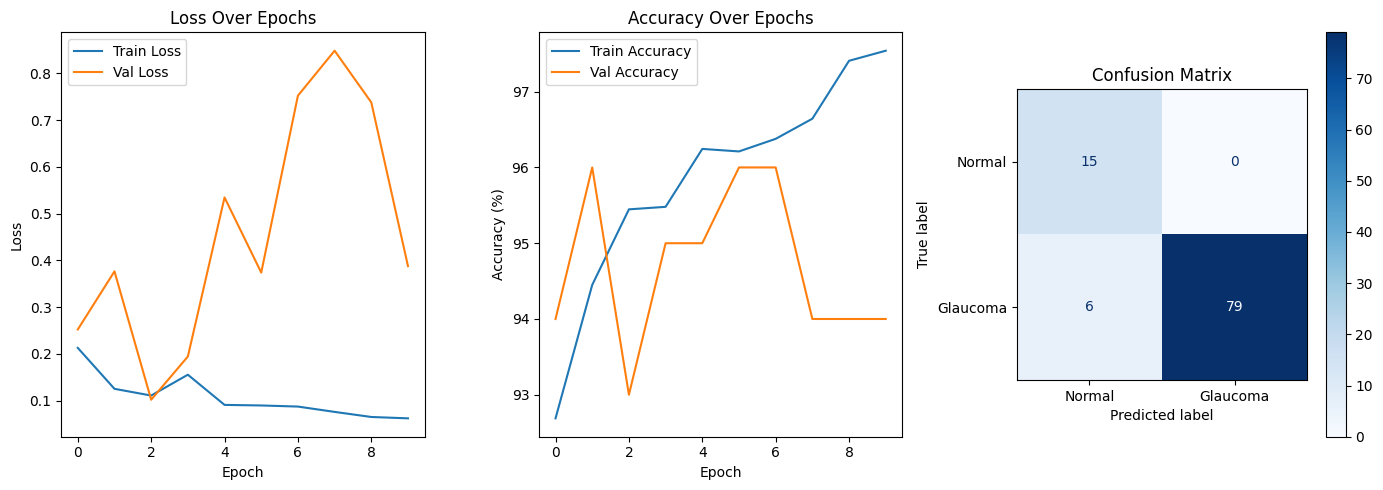

In [5]:
import os
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Plot confusion matrix only if available
plt.subplot(1, 3, 3)
if all_val_preds_by_epoch and all_val_labels_by_epoch:
    cm = confusion_matrix(all_val_labels_by_epoch[-1], all_val_preds_by_epoch[-1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix")
else:
    plt.axis("off")
    plt.title("No Confusion Matrix (empty prediction list)")

plt.tight_layout()
plt.savefig("results/resnet50_glaucoma_metrics.png")
plt.show()


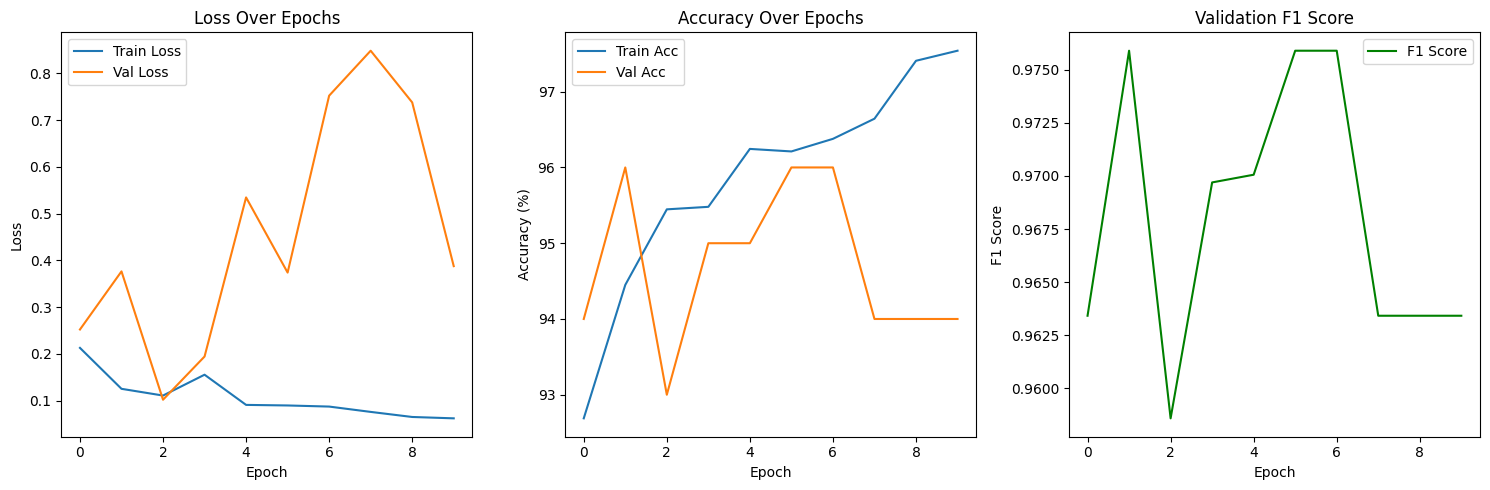

In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Prepare metric lists
val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics for each epoch
for epoch_preds, epoch_labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(epoch_labels, epoch_preds))
    val_metrics["recall"].append(recall_score(epoch_labels, epoch_preds))
    val_metrics["f1_score"].append(f1_score(epoch_labels, epoch_preds))

# Plotting
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.savefig("glaucoma_training_results.png")
plt.show()

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


=== FINAL TEST SET RESULTS ===
Test Accuracy: 0.9800 (98.00%)
Test Precision: 0.9822
Test Recall: 0.9800
Test F1-Score: 0.9805

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94         8
    Glaucoma       1.00      0.98      0.99        42

    accuracy                           0.98        50
   macro avg       0.94      0.99      0.96        50
weighted avg       0.98      0.98      0.98        50



<Figure size 800x600 with 0 Axes>

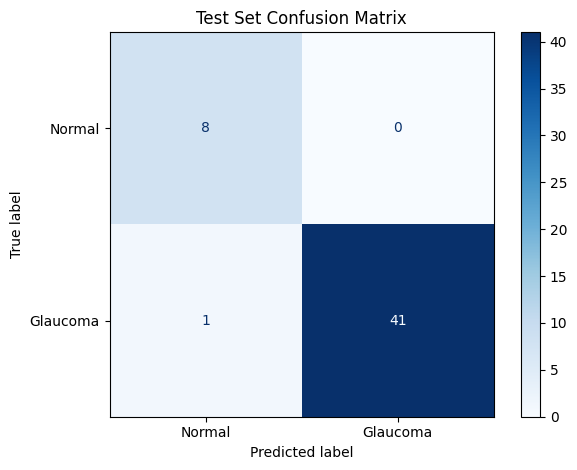

In [7]:
# Test Set Evaluation
print("Evaluating on test set...")

# Create test dataset and loader
test_dataset = CustomDataset(test_split, transform=val_transform)  # Use same transform as validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Evaluate on test set
model.eval()
test_correct, test_total = 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total

# Calculate test metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"\n=== FINAL TEST SET RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_acc:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Normal", "Glaucoma"]))

# Test confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(test_labels, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normal", "Glaucoma"])
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.savefig("test_confusion_matrix.png")
plt.show()

=== MODEL PERFORMANCE SUMMARY ===

Performance Summary:
Dataset      Accuracy   Recall     F1-Score  
---------------------------------------------
Training     0.9754     -          -         
Validation   0.9400     0.9294     0.9634    
Test         0.9800     0.9800     0.9805    

Summary saved to model_performance_summary.csv


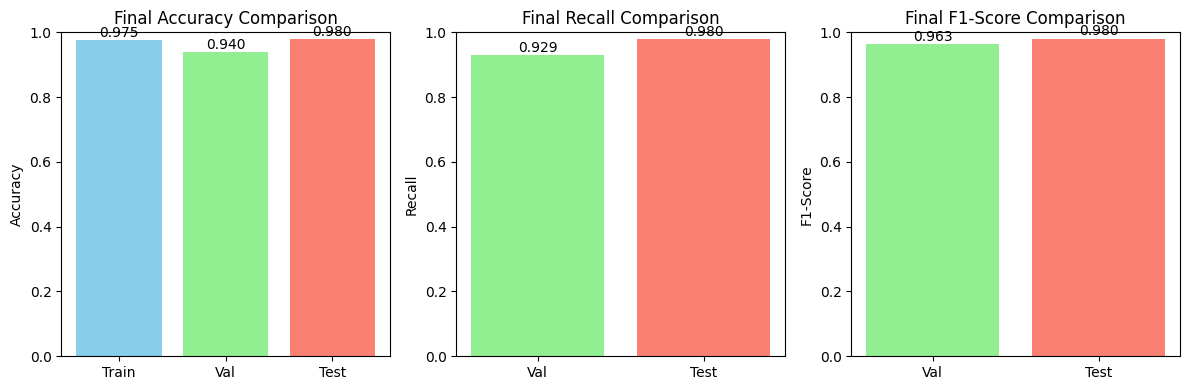

In [9]:
# Summary Comparison: Train vs Validation vs Test
print("=== MODEL PERFORMANCE SUMMARY ===")

# Get final training metrics (last epoch)
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]

# Get final validation metrics
final_val_accuracy = val_metrics["accuracy"][-1]
final_val_recall = val_metrics["recall"][-1]
final_val_f1 = val_metrics["f1_score"][-1]

# Create summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [final_train_acc/100, final_val_accuracy, test_accuracy],
    'Recall': ['-', final_val_recall, test_recall],
    'F1-Score': ['-', final_val_f1, test_f1]
}

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")

# Format and print the table manually to avoid pandas formatting issues
print(f"{'Dataset':<12} {'Accuracy':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 45)
for idx, row in summary_df.iterrows():
    dataset = row['Dataset']
    accuracy = f"{row['Accuracy']:.4f}" if isinstance(row['Accuracy'], (int, float)) else row['Accuracy']
    recall = f"{row['Recall']:.4f}" if isinstance(row['Recall'], (int, float)) else row['Recall']
    f1_score = f"{row['F1-Score']:.4f}" if isinstance(row['F1-Score'], (int, float)) else row['F1-Score']
    print(f"{dataset:<12} {accuracy:<10} {recall:<10} {f1_score:<10}")

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print(f"\nSummary saved to model_performance_summary.csv")

# Plot final comparison
plt.figure(figsize=(12, 4))

# Accuracy comparison
plt.subplot(1, 3, 1)
datasets = ['Train', 'Val', 'Test']
accuracies = [final_train_acc/100, final_val_accuracy, test_accuracy]
bars1 = plt.bar(datasets, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Recall comparison
plt.subplot(1, 3, 2)
recall_vals = [final_val_recall, test_recall]
bars2 = plt.bar(['Val', 'Test'], recall_vals, color=['lightgreen', 'salmon'])
plt.title('Final Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
for i, v in enumerate(recall_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-Score comparison
plt.subplot(1, 3, 3)
f1_vals = [final_val_f1, test_f1]
bars3 = plt.bar(['Val', 'Test'], f1_vals, color=['lightgreen', 'salmon'])
plt.title('Final F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('final_performance_comparison.png')
plt.show()